# Baseline: ecapa

In [1]:
from confidence import pipeline
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import os
import matplotlib.pyplot as plt

## Configuration

In [2]:
model_name='spkrec-ecapa-voxceleb'
dir='speaker'
root=os.path.join('results/classifier',model_name,dir)

## Data preparation

In [3]:
train, val, test=pipeline(model_name,dir,root)

/home/baole/miniconda3/envs/speechbrain/lib/python3.10/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


## Visualization

In [4]:
def visualize(dataset):
    plt.scatter(dataset[:,0],dataset[:,1])
    plt.xlabel('confidence')
    plt.ylabel('label (pos/neg)')
    plt.show()

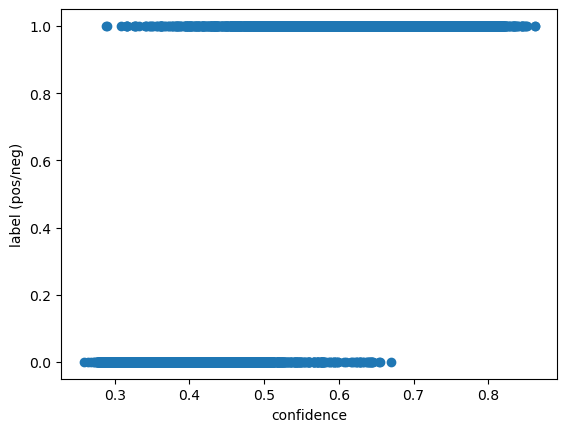

In [5]:
visualize(train)

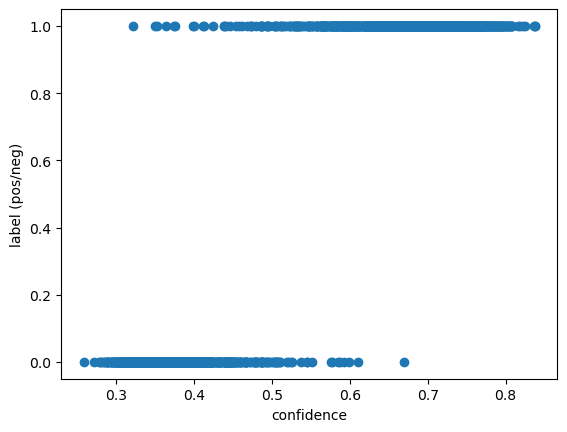

In [6]:
visualize(val)

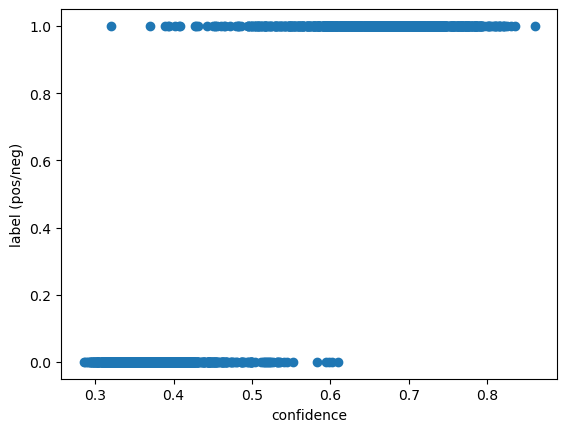

In [7]:
visualize(test)

## Evaluation

In [8]:
def classify(classifier, train, test):
    classifier.fit(train[:,:-1], train[:,-1])
    pred=classifier.predict(test[:,:-1])
    print(classification_report(test[:,-1],pred))
    RocCurveDisplay.from_estimator(classifier,test[:,:-1],test[:,-1])
    plt.show()

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1000
         1.0       0.97      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



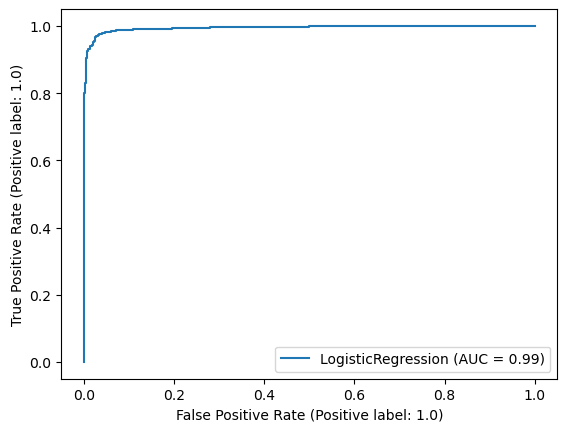

In [9]:
classify(LogisticRegression(),train,test)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1000
         1.0       0.97      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



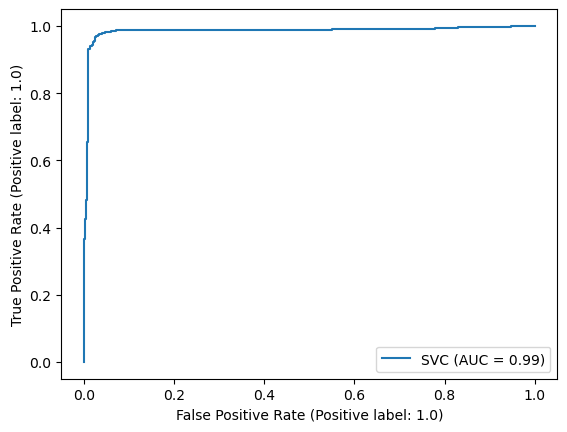

In [10]:
classify(SVC(),train,test)

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      1000
         1.0       0.95      0.96      0.96      1000

    accuracy                           0.95      2000
   macro avg       0.96      0.95      0.95      2000
weighted avg       0.96      0.95      0.95      2000



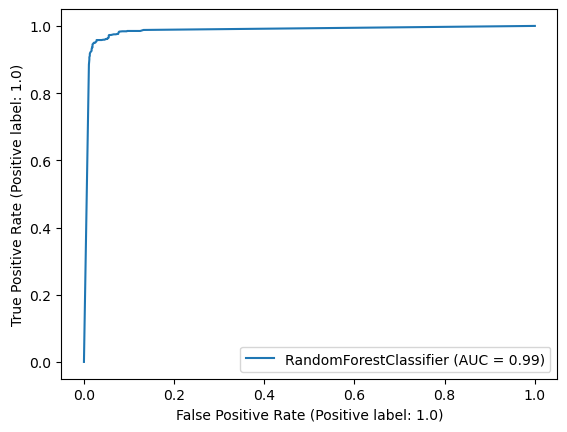

In [11]:
classify(RandomForestClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      1000
         1.0       0.96      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



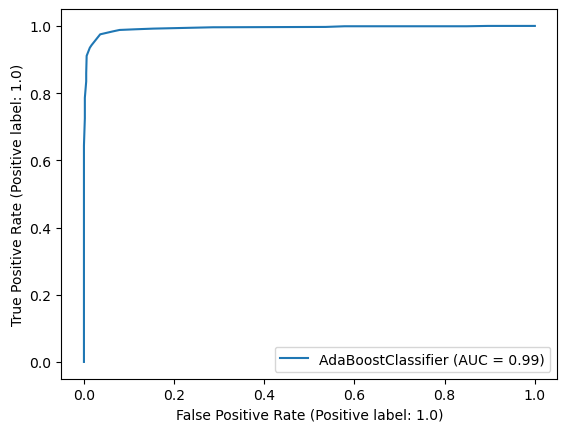

In [12]:
classify(AdaBoostClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      1000
         1.0       0.96      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



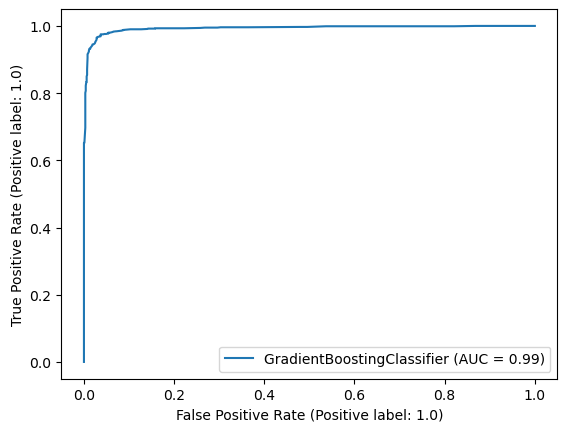

In [13]:
classify(GradientBoostingClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1000
         1.0       0.97      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



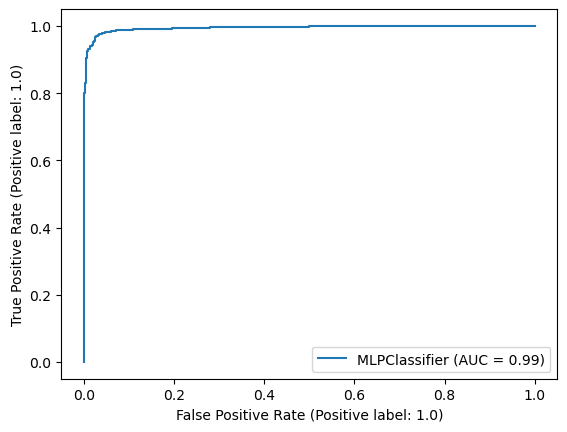

In [14]:
classify(MLPClassifier(),train,test)